In [4]:
# Imports

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, os.path
from itertools import *
import math
import random
import scipy.stats
import sys
import random
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count())
from scipy.sparse import csr_matrix
import scipy.sparse
from sklearn import cross_validation, base
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import ParameterGrid
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF

if nproc > 4:
    # timesharing env, only for part of them
    nproc = nproc * 4 // 5
    
# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
        
# Extract data in df form and as a sparse matrix

dftrain = pd.read_csv('data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max(df[c].max() for df in (dftrain, dftest) for c in ['sender', 'receiver'])
dim += 1

# both the matrices here have m[i, j] return the number of transactions from i to j
# in training.
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)
train_csc = train_csr.tocsc()

def maxlgbin(series): return math.ceil(np.log2(series.max()))

bincsr = train_csr.sign()
bincsc = train_csc.sign()
logcsr = train_csr.log1p()
logcsc = train_csc.log1p()

In [4]:
# As a NetworkX graph

import networkx as nx
import scipy
G = nx.from_scipy_sparse_matrix(train_csr, parallel_edges=False, create_using=nx.DiGraph())

Exploratory data analysis

count    3.348026e+06
mean     4.725741e+00
std      1.284948e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.163900e+04
Name: transaction, dtype: float64


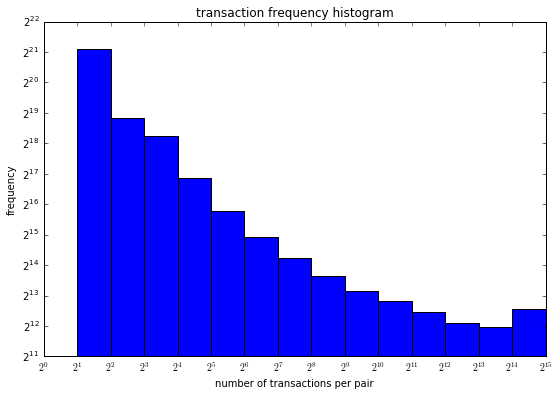

In [3]:
# Time data is not present. Thus, we'll be inferring probability of interaction
# as a stationary distribution over time, informed by the number of iteractions in the past.
series = dftrain['transaction']
title = 'transaction frequency histogram'
xlb = 'number of transactions per pair'
ylb = 'frequency'

print(series.describe())

bins = range(maxlgbin(series))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(series, bins=bins)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [51]:
n_sender = dftrain['sender'].unique().size
n_receiver = dftrain['receiver'].unique().size
n_transactions = dftrain['transaction'].sum()
n_nonmissing = dftrain['transaction'].count()
sparsity = 1 - n_nonmissing*1.0/n_sender/n_receiver
for i in ['n_sender', 'n_receiver', 'n_transactions', 'n_nonmissing', 'sparsity']: print(i, eval(i))
print('num edges', len(dftrain))

n_sender 443652
n_receiver 439602
n_transactions 15821903
n_nonmissing 3348026
sparsity 0.999982833304
num edges 3348026


count    444075.000000
mean          7.539326
std         316.680366
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max      172727.000000
dtype: float64
count    444075.000000
mean          7.539326
std         369.349803
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max      164333.000000
dtype: float64


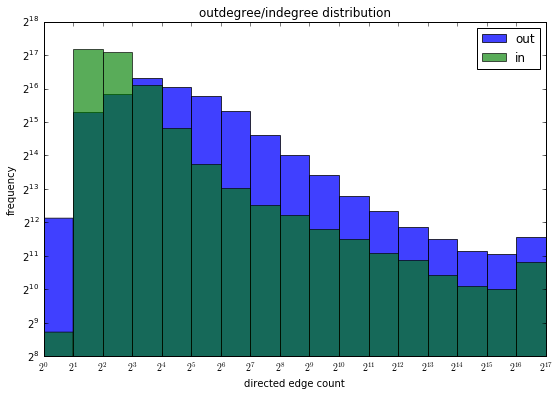

In [6]:
# Direction of edges is sender -> receiver
send_distribution = pd.Series(np.squeeze(np.asarray(bincsr.sum(0))))
recv_distribution = pd.Series(np.squeeze(np.asarray(bincsc.sum(1))))
title = 'outdegree/indegree distribution'
xlb = 'directed edge count'
ylb = 'frequency'

print(send_distribution.describe())
print(recv_distribution.describe())

# http://stackoverflow.com/questions/7694298/how-to-make-a-log-log-histogram-in-python
bins = range(max(maxlgbin(x) for x in (send_distribution, recv_distribution)))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(send_distribution, bins=bins, label='out', alpha=0.75)
plt.hist(recv_distribution, bins=bins, label='in', alpha=0.65)
plt.legend()
#plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [7]:
# Get the SCCs (memoized)
import pickle
sccs = None
try:
    with open('train_sccs.p', 'rb') as infile:
        sccs = pickle.load(infile)
except FileNotFoundError:
    print('SCC file missing, recreating SCCs')
    # This takes <1hr on cycles
    sccs = list(nx.strongly_connected_components(G))
    with open('train_sccs.p', 'wb') as outfile:
        pickle.dump(sccs, outfile)

In [8]:
print('# sccs', len(sccs))
series = pd.Series(sorted([len(scc) for scc in sccs]))
title = 'SCC size distribution'
xlb = 'scc sizes'
ylb = 'frequency'
print(series.describe())
for q in [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]:
    print('quantile', q, series.quantile(q))

# sccs 9254
count      9254.000000
mean         47.987357
std        4508.165332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      433676.000000
dtype: float64
quantile 0.9 1.0
quantile 0.99 2.0
quantile 0.999 9.747
quantile 0.9999 32866.5748997
quantile 0.99999 393595.05749
quantile 0.999999 429667.905749


In [16]:
import os
os.environ['OMP_NUM_THREADS'] = str(max(nproc // 4, 1))
old_flags = os.environ.get('THEANO_FLAGS', '')
if 'openmp' not in old_flags:
    os.environ['THEANO_FLAGS'] = old_flags + ',openmp=true' + ',openmp_elemwise_minsize=1000'

import theano, theano.sparse
print('openmp', theano.config.openmp, 'nthreads', nproc)

import time
from sklearn.preprocessing import normalize
import random

# (Takes and Kosters 2013) http://www.mdpi.com/1999-4893/6/1/100/htm
# Sample a distribution (only need about 0.1) for these metrics for each vertex
nrows = 1000
sample = random.sample(range(dim), nrows)

def timeddot(x, desc):
    t = time.time()
    y = f(x)
    print(desc, '{}K rows time'.format(nrows // 1000), time.time() - t)
    return y

x = theano.sparse.csr_matrix(name='x', dtype='float64')
y = theano.sparse.dot(x[sample], x.T)
f = theano.function([x], y)
[dotprod, binprod, logprod] = [timeddot(*x) for x in [
    (train_csr, 'regular'),
    (train_csr.sign(), 'binary'),
    (train_csr.log1p(), 'log1p')]]

openmp True nthreads 38
regular 1K rows time 2.978071689605713
binary 1K rows time 2.773721933364868
log1p 1K rows time 2.7553088665008545


In [21]:
# min data contribution
for x in ['dot', 'bin', 'log']:
    mat = eval(x + 'prod')
    data = mat.reshape(mat.size)
    print(x, 'zeros', (mat == 0).sum().sum() / mat.size)
    print(x, '(mean - median) / std', (data.mean() - np.median(data)) / data.std())
    print(x, '(99th - mean) / std', (np.percentile(data, 99) - data.mean()) / data.std())

dot zeros 0.792183604121
dot (mean - median) / std 0.0288356934379
dot (99th - mean) / std 0.178112019138
bin zeros 0.792183604121
bin (mean - median) / std 0.412398829038
bin (99th - mean) / std 1.47357872844
log zeros 0.792183604121
log (mean - median) / std 0.377840016456
log (99th - mean) / std 2.61382453177


In [32]:
# Can probably run simrank on full dot product.

In [ ]:
#1. linkpred -> figure out what this actually does
# Overall similarity-based algorithm: for undirected (Nowell Kleinberg 2007) - only works for undirected
# AA approach.
#2. graphsim -> can't use similarity(a, b) to predict interaction, but can use similarities to
# predict interaction x -> b) given interaction (x -> a) exists + outward. simrank (https://en.wikipedia.org/wiki/SimRank)
# (https://pypi.python.org/pypi/graphsim) need to find a paper for simrank to cite
# 3. Clustering -> do a coarser clustering by deleting "tenuous" edges, smarter prediction on the cluster.
# (Liben-Nowell and Kleninberg 2007)
# 4. low-rank approximation (paper above works, any other papers for)
# setup CV to evaluate all of these.
# look into NetworkX prediction

In [24]:
# Just check we never get a repeat sender
sum(train_csr[row['sender'], row['receiver']] for index, row in dftest.iterrows())

0.0

In [20]:
# Create a simple CV scheme (relying on our time-stationarity assumption)
# for evaluation.

X = dftest[['sender', 'receiver']].values.astype('float64')
Y = dftest['transaction'].values.astype('bool')
n_folds = 10
cv = cross_validation.StratifiedKFold(
    Y, n_folds=n_folds, shuffle=True, random_state=0)

def AUC(exact, pred):
    fpr, tpr, thresholds = roc_curve(exact, pred)
    return auc(fpr, tpr)

def estimatorAUC(estimator, X, Y):
    pred = estimator.predict(X)
    return AUC(Y, pred)
    
def cvAUC(estimator):
    return np.mean(cross_validation.cross_val_score(
        estimator, X, Y, scoring=estimatorAUC, cv=cv, n_jobs=n_folds, pre_dispatch=n_folds))

def expand_param_grid(f, grid):
    pg = list(ParameterGrid(grid))
    return Parallel(n_jobs=min(nproc, len(pg)))(
        delayed(f)(**p) for p in pg)

# Class that builds a grid of models in parallel
# For every p in params,
# f(p, i, j) should report a probability of a links i, j
class GridSearchEstimator(base.BaseEstimator):
    def __init__(self, f, params):
        self.params = params
        self.f = f
        self.best = None
    def fit(self, X, Y):
        best = -np.inf
        for i, t in enumerate(self.params):
            pred = [self.f(t, *x) for x in X]
            tmp = AUC(Y, pred)
            if tmp > best:
                best = tmp
                self.best = i
    def predict(self, X):
        return [self.f(self.params[self.best], *x) for x in X]

import itertools
import time

# from itertools docs
def nth(iterable, n, default=None):
    "Returns the nth item or a default value"
    return next(itertools.islice(iterable, n, None), default)

def run_auc_grid(prob, gen, grid, name):
    print('Running grid search for {}'.format(name))
    t = time.time()
    params = expand_param_grid(gen, grid)
    t = int(time.time() - t)
    print('\tcreated {} size grid in {} s'.format(len(params), t))
    t = time.time()
    gse = GridSearchEstimator(prob, params)
    avgauc = cvAUC(gse)
    t = int(time.time() - t)
    print('\tran cv with AUC {:.4f} in {} s '.format(avgauc, t))
    gse.fit(X, Y)
    best = nth(ParameterGrid(grid), gse.best)
    print('\tmodel:', best)
    
def named_matrix(A):
    if A == 'counts': return train_csr
    elif A == 'binary': return bincsr
    elif A == 'log1p': return logcsr
    return None
    
# TODO run larger grid searches for below

In [21]:
def SVDprob(svd, i, j):
    u, s, vt = svd
    return np.sum(u[i,:] * s * vt[:, j])

def makeSVD(A, k, tol, which):
    return svds(named_matrix(A), k=k, tol=tol, which=which)

grid = {
    'A': ['counts', 'binary', 'log1p'],
    'k': range(1, 6), # range(1, 21)
    'tol': [1e-10],
    'which': ['LM']}

run_auc_grid(SVDprob, makeSVD, grid, 'SVD')

Running grid search for SVD
	created 15 size grid in 16 s
	ran cv with AUC 0.7416 in 31 s 
	model: {'tol': 1e-10, 'which': 'LM', 'A': 'log1p', 'k': 4}


In [23]:
def NMFprob(nmf, i, j):
    W, H = nmf
    return W[i, :].dot(H[:, j])

def makeNMF(A, n_components, alpha, l1_ratio, init):
    nmf = NMF(n_components=n_components, init=init, alpha=alpha, l1_ratio=l1_ratio)
    W = nmf.fit_transform(named_matrix(A))
    return W, nmf.components_
    
grid = {
    'A': ['counts', 'binary', 'log1p'],
    'n_components': range(4, 5),
    'alpha': [0, 1], #[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0, 0.5, 1], #np.arange(0, 1.01, .1),
    'init': ['random', 'nndsvd', 'nndsvda']}

run_auc_grid(NMFprob, makeNMF, grid, 'NMF')

Running grid search for NMF
	created 54 size grid in 227 s
	ran cv with AUC 0.7466 in 133 s 
	model: {'n_components': 4, 'alpha': 1, 'A': 'binary', 'l1_ratio': 0, 'init': 'random'}


In [24]:
def sender(row): return bincsr.getrow(int(row['sender']))
def receiver(row): return bincsc.getcol(int(row['receiver']))
def jaccard(row):
    a = sender(row)
    b = receiver(row)
    union = a + b.transpose()
    union = union.sign()
    usize = union.dot(union.transpose())[0, 0]
    return 0 if usize == 0 else a.dot(b)[0, 0] / usize
pred = [jaccard(row) for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('in-out jaccard auc', roc_auc)

in-out jaccard auc 0.6396775
